## Generate Synthetic Data with Graphs and Datasets

Objective: Learn how to modify graphs, create datasets, access and view your generated synthetic data, and parse through dataset logs. To follow along, use the `default` cotent code when registering on the Platform or create a new workspace with this code.

Reference the latest SDK Documentation at https://sdk.rendered.ai

This example will walk through creating a new staged graph with the `example` channel and creating a dataset job in the `default` workspace that your organization will include. Then, we will walk through how to view the output files of that dataset, view masks, and learn how to create a 2D bounding box annotated image. Finally, we will learn how to view and save dataset logs for debugging purposes useful for channel development.

### Get the latest `anatools`

In [ ]:
pip install anatools --upgrade

### Set up imports and log into the SDK
These imports are required for this Notebook to run. 
Enter your credentials at the prompts. Logging in successfully will list the organizations and workspaces you have access to.

In [27]:
from zipfile import ZipFile
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import glob
import json
import pprint
import time 
import anatools

pp = pprint.PrettyPrinter(indent=2)

In [1]:
sdk = anatools.client()

Enter your credentials for the Rendered.ai Platform.
Email: email@rendered.ai
········
These are your organizations and workspaces:
    default Organization                          e8af8e7e-60d3-415f-a88d-9f4e191afec4              
	Example                                   c721696e-648f-4572-a9ca-5dd72f1e8f58              
The current workspaces is: c721696e-648f-4572-a9ca-5dd72f1e8f58


### Set your Workspace
First, switch into the default workspace in case that is not the one you are working from. Use `get_workspaces()` to get the list of workspaces you have access to, then filter it to get the id of the default workspace.

In [10]:
workspaces = sdk.get_workspaces()
#pp.pprint(workspaces)
example_workspace_id = next(wkspc for wkspc in workspaces if wkspc['name']=='Example')['workspaceId']
print('Example workspace Id: ' + example_workspace_id)

Example workspace Id: c721696e-648f-4572-a9ca-5dd72f1e8f58


Now, use `set_workspace()` to switch into the default workspace.

In [11]:
sdk.set_workspace(workspaceId=example_workspace_id)

Organization set to e8af8e7e-60d3-415f-a88d-9f4e191afec4.
Workspace set to c721696e-648f-4572-a9ca-5dd72f1e8f58.


### Create a Staged Graph with the `example` Channel
Now we are ready to start creating synthetic data! Run `get_channels()` to get the `example` channel id and then use `get_default_graph()` to view the json of a default graph. 

In [12]:
channels = sdk.get_channels()
example_channel_id = next(channel for channel in channels if channel['name']=='example')['channelId']
print('Example Channel Id: ' + example_channel_id + '\n')

default_graph = sdk.get_default_graph(channelId=example_channel_id)
default_graph_json = json.loads(default_graph)
pp.pprint(default_graph_json)

Example Channel Id: 2b5e2318-83a0-487f-b15d-96bd7301ab74

{   'nodes': {   'Bubbles_7': {   'links': {},
                                  'nodeClass': 'Bubbles',
                                  'values': {}},
                 'ColorVariation_4': {   'links': {   'Generators': [   {   'outputPort': 'Yoyo '
                                                                                          'Generator',
                                                                            'sourceNode': 'YoYo_9'},
                                                                        {   'outputPort': 'Play '
                                                                                          'Dough '
                                                                                          'Generator',
                                                                            'sourceNode': 'Playdough_10'},
                                                                        {   'ou

Now that we have the default graph json, let's generate a staged graph. Run `create_staged_graph()` with the json of the default graph that we saved.

In [13]:
staged_graph_id = sdk.create_staged_graph(name='Example Staged Graph', channelId=example_channel_id, graph=default_graph_json)
print('Staged Graph Id: ' + staged_graph_id)

Staged Graph Id: ba2c4f03-11fe-4f08-912f-ce76d54b3b73


Run `get_staged_graphs()` with the id of the staged graph we created to ensure that it is in the workspace.

In [14]:
sdk.get_staged_graphs(graphId=staged_graph_id)

[{'graphid': 'ba2c4f03-11fe-4f08-912f-ce76d54b3b73',
  'name': 'Example Staged Graph',
  'channel': '2b5e2318-83a0-487f-b15d-96bd7301ab74',
  'user': 'email@rendered.ai',
  'deleted': False,
  'description': None}]

### Create a Dataset
Now that the staged graph is in place, let's start a dataset job. Run `create_dataset()` with the staged graph id to kick off a dataset job. We will set `runs=1` so there is only 1 image generated.

In [15]:
dataset_id = sdk.create_dataset(name='Example Dataset', graphId=staged_graph_id, runs=1)
print('Dataset ID: ' + dataset_id)

Dataset ID: 6e396ea6-e394-4566-8259-76bcadc16ab7


Once the dataset job starts, the dataset status will show as `queued` initially. This status will update and go through several phases as the job processes. Monitor the dataset with `get_datasets()` until the status shows as `complete`. 

In [20]:
datasets = sdk.get_datasets(datasetId=dataset_id)
pp.pprint(datasets)

[   {   'channel': 'example',
        'count': '0',
        'datasetId': '6e396ea6-e394-4566-8259-76bcadc16ab7',
        'description': '',
        'files': '0',
        'graphId': 'ba2c4f03-11fe-4f08-912f-ce76d54b3b73',
        'interpretations': '1',
        'name': 'Example Dataset',
        'priority': '1',
        'seed': '1',
        'size': '0',
        'status': 'running',
        'type': 'synthetic',
        'user': 'email@rendered.ai'}]


This dataset is now complete.

In [29]:
datasets = sdk.get_datasets(datasetId=dataset_id)
pp.pprint(datasets)

[   {   'channel': 'example',
        'count': '1',
        'datasetId': '6e396ea6-e394-4566-8259-76bcadc16ab7',
        'description': '',
        'files': '1',
        'graphId': 'ba2c4f03-11fe-4f08-912f-ce76d54b3b73',
        'interpretations': '1',
        'name': 'Example Dataset',
        'priority': '1',
        'seed': '1',
        'size': '878997',
        'status': 'complete',
        'type': 'synthetic',
        'user': 'email@rendered.ai'}]


### Download the Dataset and explore the files

Downloading the dataset files allows us to view images, masks, metadata, and the matching graph in yaml format associated with the dataset. 

Run `download_dataset()` with the id of the completed dataset job. Then use `ZipFile` library to extract it and view the image with the `matplotlib` library. Read through [this guide](https://support.rendered.ai/rd/Working-With-Datasets.1577123882.html#WorkingWithDatasets-CommonDirectoryStructure) that explains the common directory structure of downloaded datasets. 

Use your file explorer to navigate to the directory that this notebook is running in to view the files of the downloaded dataset. Note that both the zip and unzipped dataset folders for `6e396ea6-e394-4566-8259-76bcadc16ab7` are included in this directory.

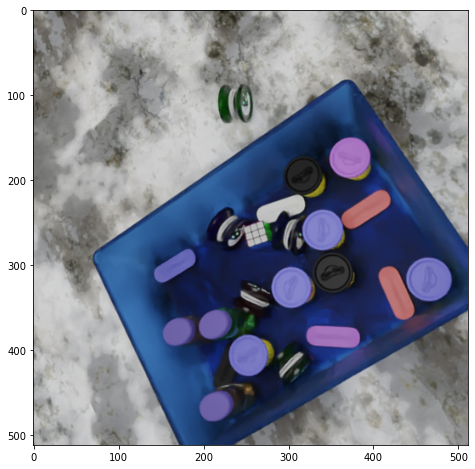

In [31]:
downloaded_dataset = sdk.download_dataset(datasetId=dataset_id)

zf = ZipFile(downloaded_dataset, 'r')
zf.extractall(downloaded_dataset.split('.')[0])
zf.close()

example_image = Image.open(glob.glob(downloaded_dataset.split('.')[0]+"/images/*.png")[0], 'r')
plt.figure(figsize = (8,8))
plt.imshow(np.asarray(example_image))

### View Image Masks 
The downloaded dataset directory comes with image masks that show how the placement of the objects match the generated  images. 

Use the `matplotlib` library to view the object masks.

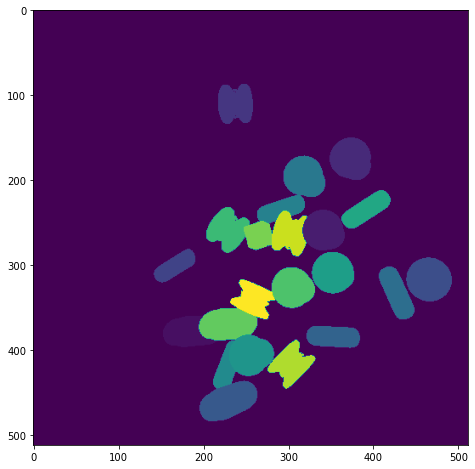

In [32]:
example_image_mask = Image.open(glob.glob(downloaded_dataset.split('.')[0]+"/masks/*.png")[0], 'r')
plt.figure(figsize = (8,8))
plt.imshow(np.asarray(example_image_mask))

### Create an image Annotated with 2d Bounding Boxes
This example will walk through how to generate images with 2d bounding boxes on your local system. 

Use the `bounding_box_2d` function to generate the annotated image from the single image file within the dataset. Here, we will choose to filter the drawings on the `YoYo` type and set line thickness=2. For more information on annotations, read through the [Generating Annotations Notebook](../3_anatools_for_ML/Generate%20Annotations%20for%20Datasets.ipynb)

In [50]:
from anatools import annotations

# Define data_dir here, default is the downladed dataset
data_dir = "../1_getting_started/6e396ea6-e394-4566-8259-76bcadc16ab7"

#Create the needed annotations directory
draw_dir = os.path.join(data_dir, 'draw_annotations')
if not os.path.isdir(draw_dir):
    os.mkdir(draw_dir)
    
annotations = annotations()
annotations.bounding_box_2d(image_path=glob.glob(downloaded_dataset.split('.')[0]+"/images/*.png")[0], 
                                out_dir=draw_dir, object_types=['YoYo'], line_thickness=2)

Image saved to ../1_getting_started/6e396ea6-e394-4566-8259-76bcadc16ab7/draw_annotations/0000000000-250-RGBCamera-annotated-box_2d.png


### View the images with the bounding boxes
Note that all the YoYo's in the resulting image show up with green lines. Currently, the colors of the boxes are generated dynamically.

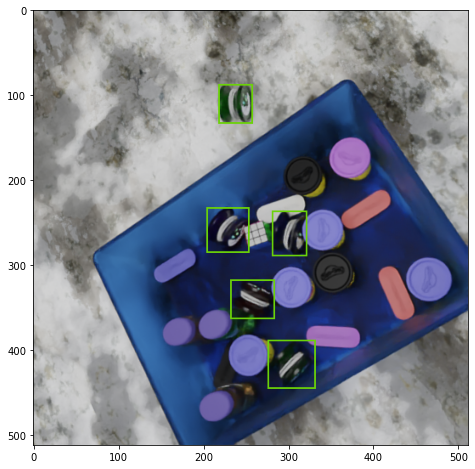

In [51]:
image_file_name = glob.glob(draw_dir+"/*2d.png")[0].split('/')[4]
annotated_image_2d = Image.open(draw_dir+"/"+image_file_name)
plt.figure(figsize = (8,8))
plt.imshow(np.asarray(annotated_image_2d))

## View Dataset Logs

This example will walk through how to view logs for a dataset. These logs are equivalent to the console output you would see if you generated the dataset through the ANA development environment.

### View the latest dataset runs 
Viewing dataset logs requires using a `runId`. Use the `get_dataset_runs()` command and get the latest `runId`. 

In [51]:
runs = sdk.get_dataset_runs(datasetId=dataset_id)
run_id = runs[0]['runId']
pp.pprint(runs)

[   {   'channelId': '2b5e2318-83a0-487f-b15d-96bd7301ab74',
        'datasetId': '6e396ea6-e394-4566-8259-76bcadc16ab7',
        'endTime': '2022-04-11T21:47:21.787Z',
        'run': 0,
        'runId': '8d5c6f95-9da3-4c5e-a73c-0b1023816089',
        'startTime': '2022-04-11T21:47:21.787Z',
        'state': 'succeeded',
        'workspaceId': 'c721696e-648f-4572-a9ca-5dd72f1e8f58'}]


### View the log of a run
Now, use `get_dataset_log` to get the log for this specific run. Note that the actual log would be much larger and this particular log has been edit for brevity.

In [48]:
sdk.get_dataset_log(datasetId=dataset_id, runId=run_id)

'[{"timestamp":1649780919332,"message":"ERROR (bke.lib_id): /home/sources/buildbot-worker-linux_centos7/linux_290/blender.git/source/blender/blenkernel/intern/lib_id.c:283 id_us_min: ID user decrement error: MADots Stroke (from \'[Main]\'): 0 <= 0","ingestionTime":1649780920342},{"timestamp":1649780922209,"message":"2022-04-12 16:28:42 ana.channels.example.lib.setup INFO - Enabled CUDA device Tesla K80.","ingestionTime":1649780925328},{"timestamp":1649780922209,"message":"2022-04-12 16:28:42 ana.channels.example.lib.setup INFO - Enabled CUDA device Intel Xeon CPU E5-2686 v4 @ 2.30GHz.","ingestionTime":1649780925328},{"timestamp":1649780922262,"message":"2022-04-12 16:28:42 ana.packages.common.lib.node INFO - Creating node \'Bubbles_9\', class = \'BubblesNode\'","ingestionTime":1649780925328},{"timestamp":1649780922262,"message":"2022-04-12 16:28:42 ana.packages.common.lib.node INFO - Configuring node \'Bubbles_9\', class = \'BubblesNode\'","ingestionTime":1649780925328},{"timestamp":16

### Save run log
As can be seen, this log is hard to read. We can save it to a log file to read it instead. Use `get_dataset_log` with `saveLogFile=True` to save it to a log file. The example below shows what this log file looks like, but it has been edited for brevity. Navigate to the log file within this directory to view the full output.

In [49]:
sdk.get_dataset_log(datasetId=dataset_id, runId=run_id, saveLogFile=True)

Saved log to 2b5e2318-83a0-487f-b15d-96bd7301ab74-7679c996-a314-4b17-810f-d3694fdc8c05.log


In [ ]:
# %load 2b5e2318-83a0-487f-b15d-96bd7301ab74-7679c996-a314-4b17-810f-d3694fdc8c05.log
ERROR (bke.lib_id): /home/sources/buildbot-worker-linux_centos7/linux_290/blender.git/source/blender/blenkernel/intern/lib_id.c:283 id_us_min: ID user decrement error: MADots Stroke (from '[Main]'): 0 <= 0
2022-04-12 16:28:42 ana.channels.example.lib.setup INFO - Enabled CUDA device Tesla K80.
2022-04-12 16:28:42 ana.channels.example.lib.setup INFO - Enabled CUDA device Intel Xeon CPU E5-2686 v4 @ 2.30GHz.
2022-04-12 16:28:42 ana.packages.common.lib.node INFO - Creating node 'Bubbles_9', class = 'BubblesNode'
2022-04-12 16:28:42 ana.packages.common.lib.node INFO - Configuring node 'Bubbles_9', class = 'BubblesNode'
2022-04-12 16:28:42 ana.packages.common.lib.node INFO - Creating node 'Color Variation_6', class = 'ColorVariationModifier'
2022-04-12 16:28:42 ana.packages.common.lib.node INFO - Configuring node 'Color Variation_6', class = 'ColorVariationModifier'
2022-04-12 16:28:42 ana.packages.common.lib.node INFO - Creating node 'Container_1', class = 'ContainerNode'
...
Saved: /generates/datasets/948bbc29-c8e6-410f-8ff3-29bd07659098/output/masks/0000000000-250-RGBCamera-obj025.png
Saved: /generates/datasets/948bbc29-c8e6-410f-8ff3-29bd07659098/output/images/0000000000-250-RGBCamera.png-obj025.png
Fra:250 Mem:80.19M (Peak 229.47M) | Time:00:02.64 | Sce: example Ve:0 Fa:0 La:0
2022-04-12 16:30:46 ana.packages.common.lib.scene INFO - Writing annotations to: /generates/datasets/948bbc29-c8e6-410f-8ff3-29bd07659098/output/annotations/0000000000-250-RGBCamera-ana.json
2022-04-12 16:30:47 ana.packages.common.lib.scene INFO - Writing metadata to: /generates/datasets/948bbc29-c8e6-410f-8ff3-29bd07659098/output/metadata/0000000000-250-RGBCamera-metadata.json
Number Objects Rendered: 21
Elapsed Time: 128.836sec
Blender quit
Error: Not freed memory blocks: 4, total unfreed memory 0.005035 MB